# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
!pip install -q scikit-plot
import scikitplot as skplt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#for finding nonzero elements in sparse matrix
from scipy.sparse import find
#for f1_Score
from sklearn.metrics import f1_score
#for roc curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import coo_matrix, hstack
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
#for SGD
from sklearn.linear_model import LogisticRegression
#for SVC
from sklearn.svm import SVC
#for others
from tqdm import tqdm
import os
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from prettytable import PrettyTable

You should consider upgrading via the 'python -m pip install --upgrade pip' command.
C:\Users\shubh\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [03:09<00:00, 1839.11it/s]


In [23]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='b'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
final['Text'] = preprocessed_reviews
#balancing the data
finalp = final[final.Score == 1].sample(22500,random_state =2)
finaln = final[final.Score == 0].sample(22500,random_state =2)
finalx = pd.concat([finalp,finaln],ignore_index=True)
finalx = finalx.sort_values('Time')
X = finalx.Text
#Sampling 5k points for Agglomerative and DBScan . Also balancing the data
finalp = final[final.Score == 1].sample(4000,random_state =2)
finaln = final[final.Score == 0].sample(4000,random_state =2)
finalx = pd.concat([finalp,finaln],ignore_index=True)
finalx = finalx.sort_values('Time')
X_dash = finalx.Text




# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW for Kmeans
scaler = StandardScaler(with_mean=False)
count_vect1 = CountVectorizer(ngram_range=(1,2),min_df=10) #in scikit-learn
bow_vec_X = count_vect1.fit_transform(X)
bow_vec_X = scaler.fit_transform(bow_vec_X)
print("some feature names ", count_vect1.get_feature_names()[:10])
print('='*50)



C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


some feature names  ['abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish']


## [4.3] TF-IDF

In [26]:
scaler = StandardScaler(with_mean=False)
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_X = tf_idf_vect1.fit_transform(X)
tf_idf_X = scaler.fit_transform(tf_idf_X)
print("some sample features(unique words in the corpus)",tf_idf_vect1.get_feature_names()[0:10])
print('='*50)





some sample features(unique words in the corpus) ['abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish']


## [4.4] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
#For k means
i=0
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

w2v_model_X=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model_X.wv.most_similar('great'))
print('='*50)
print(w2v_model_X.wv.most_similar('worst'))

w2v_words_X = list(w2v_model_X.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_X))
print("sample words ", w2v_words_X[0:50])
    
#For agglomerative and DBSCAN
    
i=0
list_of_sentance=[]
for sentance in X_dash:
    list_of_sentance.append(sentance.split())

w2v_model_X_dash=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model_X_dash.wv.most_similar('great'))
print('='*50)
print(w2v_model_X_dash.wv.most_similar('worst'))

w2v_words_X_dash = list(w2v_model_X_dash.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_X_dash))
print("sample words ", w2v_words_X_dash[0:50])


[('fantastic', 0.8348206877708435), ('wonderful', 0.8335289359092712), ('good', 0.8205147385597229), ('excellent', 0.809248149394989), ('awesome', 0.7966448664665222), ('amazing', 0.7397936582565308), ('perfect', 0.728564441204071), ('terrific', 0.7216640114784241), ('fabulous', 0.6715311408042908), ('decent', 0.6629877090454102)]
[('nastiest', 0.8247660994529724), ('greatest', 0.7542445659637451), ('best', 0.7536300420761108), ('disgusting', 0.6683645844459534), ('terrible', 0.6365768909454346), ('superior', 0.6301916241645813), ('saltiest', 0.6276607513427734), ('worse', 0.6265511512756348), ('vile', 0.6187922358512878), ('horrible', 0.6169929504394531)]
number of words that occured minimum 5 times  13564
sample words  ['always', 'enjoyed', 'movie', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'something', 'eliminated', 'strong', 'elements', 'usually', 'edited', 'television', 'version', 'warned', 'want', 'avoid', 'mi

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [28]:
# average Word2Vec
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())
sent_vectors_X = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_X:
            vec = w2v_model_X.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_X.append(sent_vec)
print(len(sent_vectors_X))
print(len(sent_vectors_X[0]))
scaler = StandardScaler() 
sent_vectors_X = scaler.fit_transform(sent_vectors_X)


# average Word2Vec
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_dash:
    list_of_sentance.append(sentance.split())
sent_vectors_X_dash = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_X_dash:
            vec = w2v_model_X_dash.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_X_dash.append(sent_vec)
print(len(sent_vectors_X_dash))
print(len(sent_vectors_X_dash[0]))
scaler = StandardScaler() 
sent_vectors_X_dash = scaler.fit_transform(sent_vectors_X_dash)

100%|███████████████████████████████████████████████████████████████████████████| 45000/45000 [02:04<00:00, 360.50it/s]


45000
50


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:14<00:00, 547.08it/s]


8000
50


#### [4.4.1.2] TFIDF weighted W2v

In [29]:
#FOR KMEANS
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model1 = TfidfVectorizer()
tf_idf_matrix1 = model1.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model1.get_feature_names(), list(model1.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat1 = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())
tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_X and word in tfidf_feat1:
            vec = w2v_model_X.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1
    
scaler = StandardScaler() 
tfidf_sent_vectors1 = scaler.fit_transform(tfidf_sent_vectors1)

100%|████████████████████████████████████████████████████████████████████████████| 45000/45000 [30:48<00:00, 24.34it/s]


In [30]:
#FOR Agglomertive and DBSCAN
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model2 = TfidfVectorizer()
tf_idf_matrix2 = model2.fit_transform(X_dash)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model2.get_feature_names(), list(model2.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat2 = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

list_of_sentance=[]
for sentance in X_dash:
    list_of_sentance.append(sentance.split())
tfidf_sent_vectors2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_X_dash and word in tfidf_feat2:
            vec = w2v_model_X_dash.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors2.append(sent_vec)
    row += 1
    
scaler = StandardScaler() 
tfidf_sent_vectors2 = scaler.fit_transform(tfidf_sent_vectors2)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.09it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [31]:
#We define a function for hyperparameter tuning of KMeans
def kalgo(vector):
    ssd = []
    k = []
    for x in range(2,40,5):
        kmeans = KMeans(n_clusters=x, random_state=0, n_jobs=-1).fit(vector)
        ssd.append(kmeans.inertia_)
        k.append(x)


    plt.figure()
    plt.plot(k,ssd,'bx-')
    plt.xlabel("Sum of squared distances")
    plt.ylabel("No. of clusters")
    plt.show()

In [32]:
#Define a function for wordcloud generation for AVG W2V and weighted avg TFIDF
def wrdcld(data,labels):
    nclusters = max(labels)
    new = pd.DataFrame(data,labels)
    d = {}
    for i in range(0,nclusters+1):
        d["string{0}".format(i)]=str(new[new.index==i])
        wordcloud = WordCloud(colormap="Oranges_r").generate(d["string{0}".format(i)])
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [86]:
#Define a function for wordcloud generation for BoW and TFIDF
def wd(vector,max):
    d = {}
    
    for i in range(0,max+1):
        d["string{0}".format(i)]= w[i:i+1]
        features = vector.get_feature_names()
        df = pd.DataFrame(d["string{0}".format(i)], columns = features).T
        topdf = df[df[0] > 0]
        words = str(topdf[0].sort_values(ascending=False))
        wordcloud = WordCloud(colormap="Oranges_r").generate(words)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

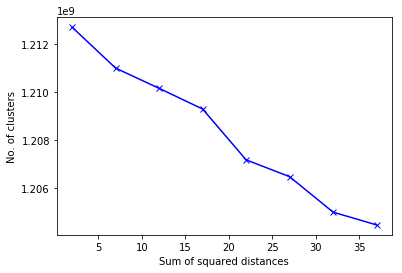

In [33]:
kalgo(bow_vec_X)

In [34]:
model = KMeans(n_clusters=7, random_state=0, n_jobs=-1).fit(bow_vec_X)
w = model.cluster_centers_

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

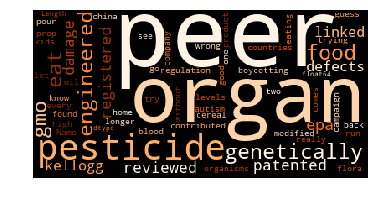

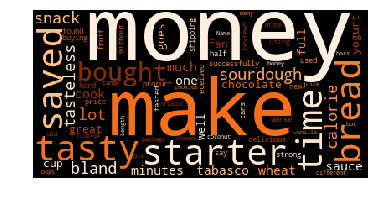

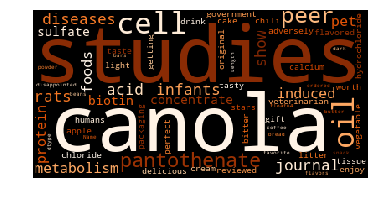

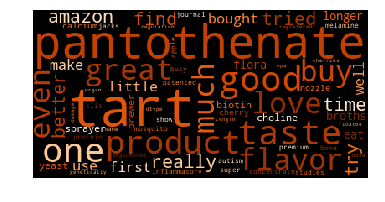

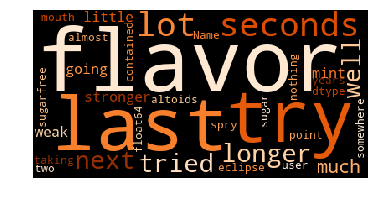

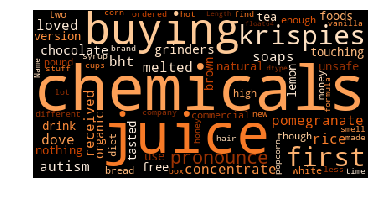

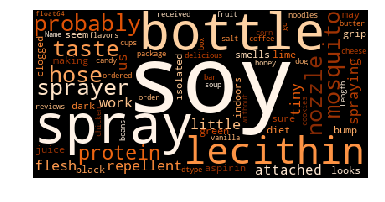

In [75]:
wd(count_vect1,6)

No. of clusters found by hyperparameter tuning = 7
Wordclouds representations by sequence: 
    1) It represents biologically related things such as food, organs , pesticide,etc
    2) Related to food, starters, bread etc.
    3) Related to biotics such as acids, proteins, and studies of the same.
    4) It is generalised which includes love, taste, flavor, etc
    5) Related to flavors such as mint, spicy , etc
    6) Related to buying things such as chemicals, juice, soap , etc
    7) Related to liquids such as nozzle of a bottle, mosquito spray, bottle, etc

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

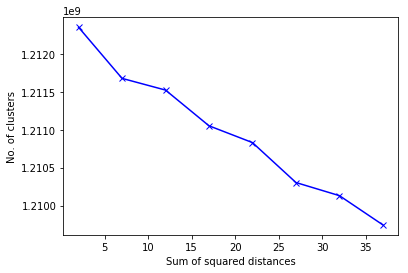

In [76]:
kalgo(tf_idf_X)

In [103]:
model = KMeans(n_clusters=6, random_state=0, n_jobs=-1).fit(tf_idf_X)
w = model.cluster_centers_

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

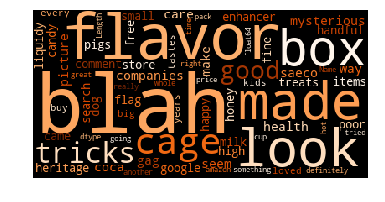

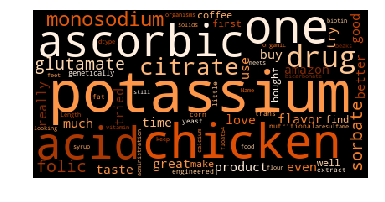

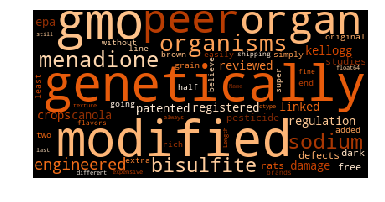

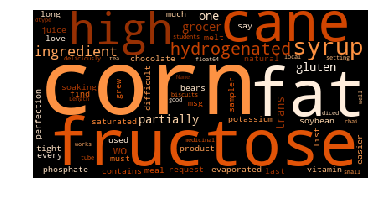

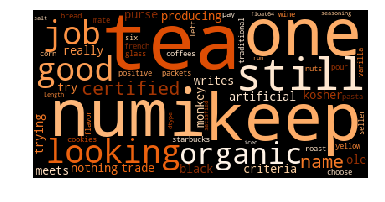

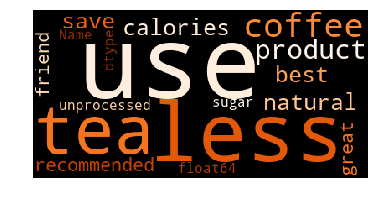

In [107]:
wd(tf_idf_vect1,5)

No. of clusters found by hyperparameter tuning = 6
Wordclouds representations by sequence: 
    1) Related to looks and health.
    2) Related to chemicals such as potassium, acid, etc
    3) Related to biology such as genetically modified organisms.
    4) Related to food such as corn, fat, fructose, etc
    5) Related to career terms such as certified, artificial,crtieria,job,etc
    6) Related to beverages such as tea, coffee, calories, etc

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

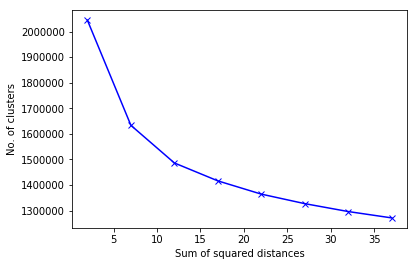

In [108]:
kalgo(sent_vectors_X)

In [109]:
model = KMeans(n_clusters=7, random_state=0, n_jobs=-1).fit(sent_vectors_X)
w = model.labels_

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

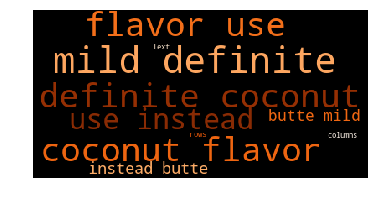

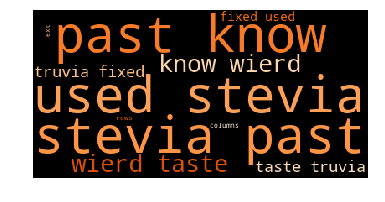

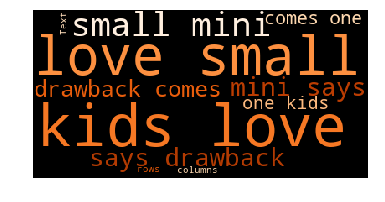

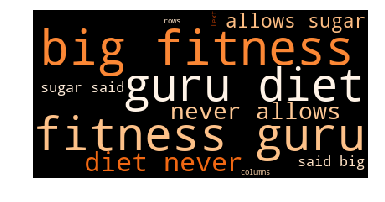

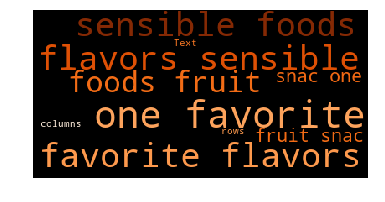

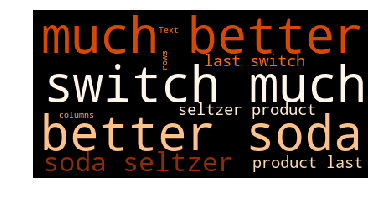

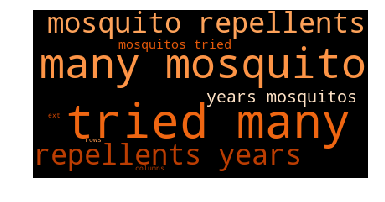

In [110]:
wrdcld(X,w)

No. of clusters found by hyperparameter tuning = 7
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, used, etc
    3) Related to love, kids, etc
    4) Related to fitness regime such as diet , fitness, sugar, etc
    5) Related to food such as food, fruit, etc
    6) Related to words such as much better,last switch and soda.
    7) Related to mosquito repellents.

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

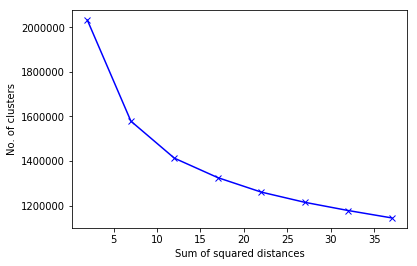

In [111]:
kalgo(tfidf_sent_vectors1)

In [112]:
model = KMeans(n_clusters=7, random_state=0, n_jobs=-1).fit(tfidf_sent_vectors1)
w= model.labels_

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

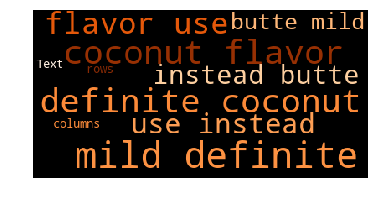

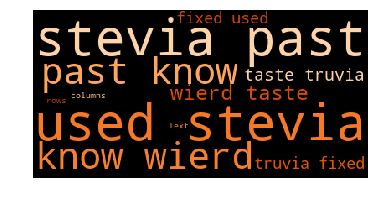

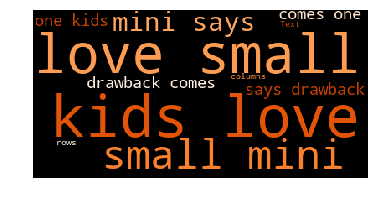

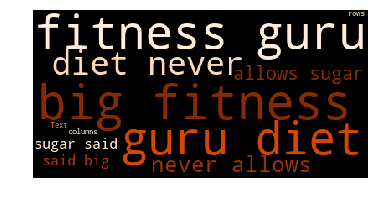

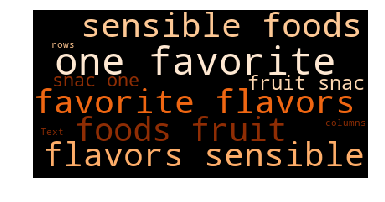

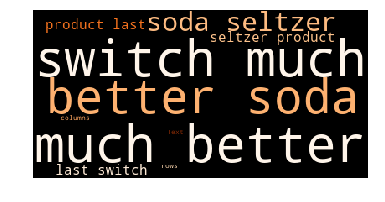

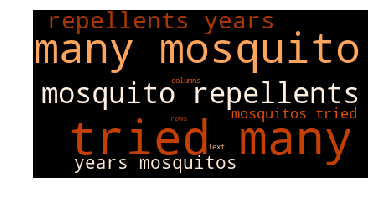

In [113]:
wrdcld(X,w)

No. of clusters found by hyperparameter tuning = 7
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc
    3) Related to general terms such as love , kids, small ,etc
    4) Related to fitness regime terms such as fitness, guru, diet, etc
    5) Related to food terms such as foods, flavors, etc
    6) Related to terms such as soda, much better , etc
    7) Related to mosquitos and mosquito repellent.

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [114]:
#default n_cluster=2
model = AgglomerativeClustering().fit(sent_vectors_X_dash)
w = model.labels_

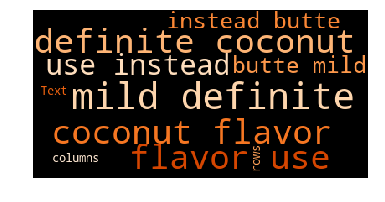

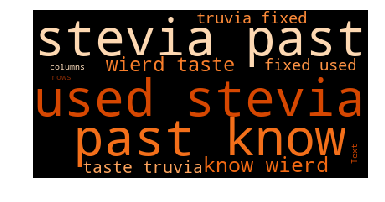

In [115]:
wrdcld(X_dash,w)

No. of clusters=2
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc

### [5.2.2] Changing n_clusters,applying agglomerative and also displaying wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [116]:
#Changing n_cluster to 5
model = AgglomerativeClustering(n_clusters=5).fit(sent_vectors_X_dash)
w = model.labels_

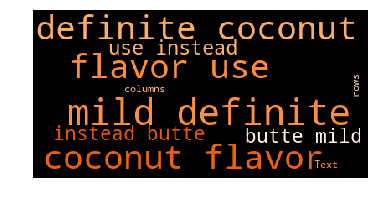

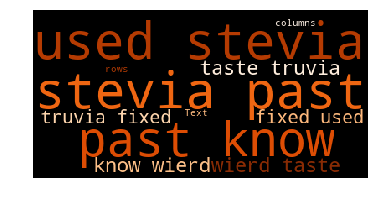

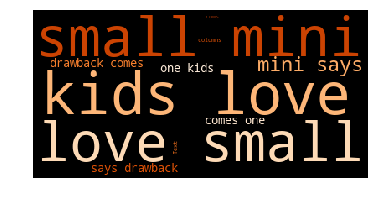

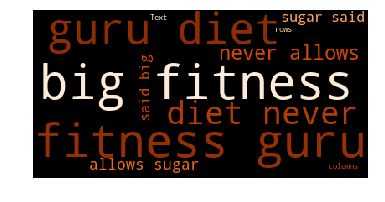

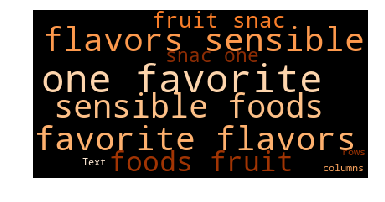

In [117]:
wrdcld(X_dash,w)

No. of clusters = 5
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc
    3) Related to general terms such as love , kids, small ,etc
    4) Related to fitness regime terms such as fitness, guru, diet, etc
    5) Related to food terms such as foods, flavors, etc

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [118]:
#Default n_cluster=2
model = AgglomerativeClustering().fit(tfidf_sent_vectors2)
w = model.labels_

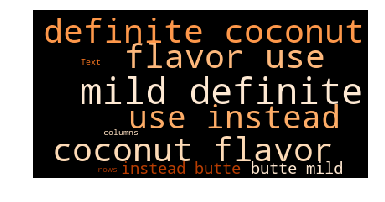

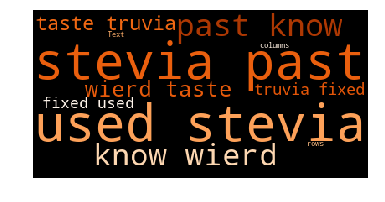

In [119]:
wrdcld(X_dash,w)

No. of clusters = 2 
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc
  

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

In [120]:
#Running agglomerative on 5 clusters
model = AgglomerativeClustering(n_clusters=5).fit(tfidf_sent_vectors2)
w = model.labels_

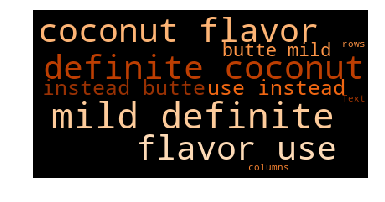

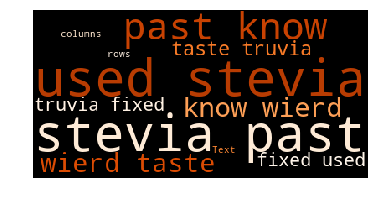

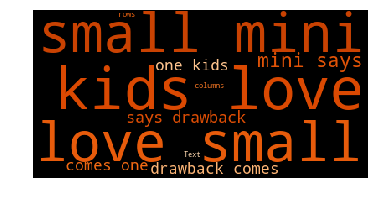

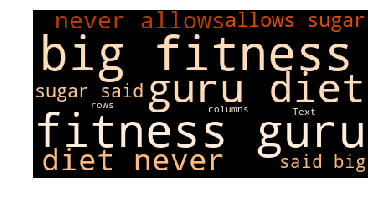

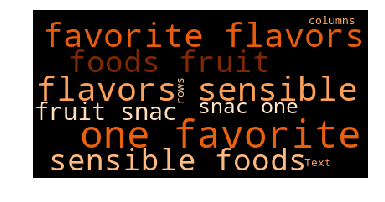

In [121]:
wrdcld(X_dash,w)

No. of clusters = 5
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc
    3) Related to general terms such as love , kids, small ,etc
    4) Related to fitness regime terms such as fitness, guru, diet, etc
    5) Related to food terms such as foods, flavors, etc

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

Defining a function to hyperparamter tune eps.
For hyperparameter tuning,use of core sample points density is used. As eps increases, no. of core points also increase.
At some point, it will remain the same.
For this, knee plot is used.


In [126]:
def DB(vector):
    eps=[]
    corepts = []
    for i in [0.7,1.0,1.5,2,2.5,3,4,5,6,7,8,9]:
        model = DBSCAN(eps=i).fit(vector)
        corepts.append(max(model.core_sample_indices_.shape))
        eps.append(i)
    
    plt.plot(corepts,eps,'bx-')
    plt.xlabel("No. of core points")
    plt.ylabel("Distance(eps)")
    plt.title("Knee plot")
    plt.show()
    

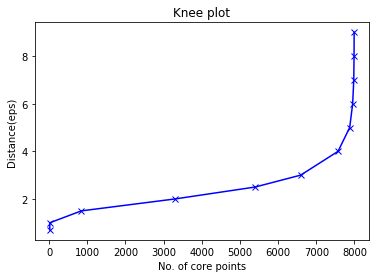

In [127]:
DB(sent_vectors_X_dash)

In [128]:
model = DBSCAN(eps=4).fit(sent_vectors_X_dash)
w = model.labels_

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

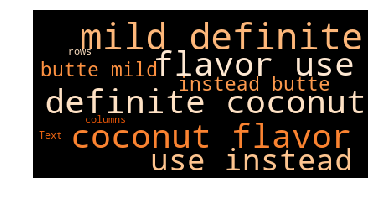

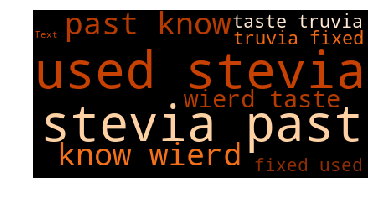

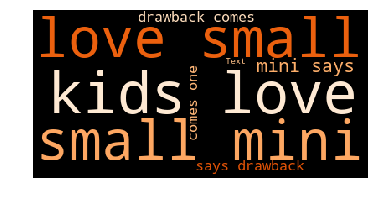

In [129]:
wrdcld(X_dash,w)

No. of clusters found by hyperparameter tuning = 3
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc
    3) Related to general terms such as love , kids, small ,etc

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

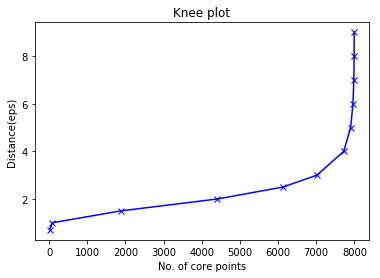

In [130]:
DB(tfidf_sent_vectors2)

In [131]:
model = DBSCAN(eps=3.5).fit(tfidf_sent_vectors2)
w = model.labels_

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

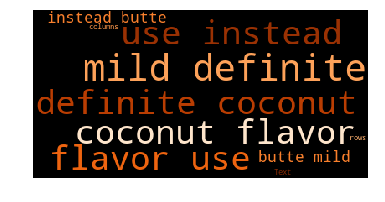

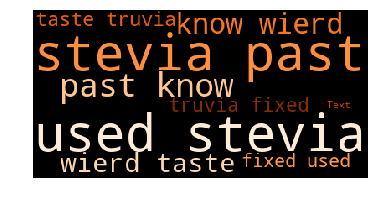

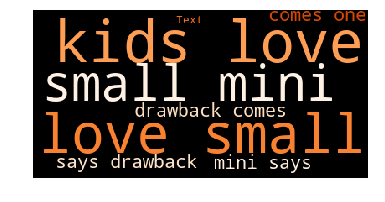

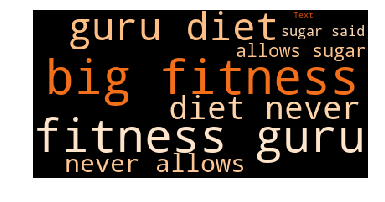

In [132]:
wrdcld(X_dash,w)

No. of clusters found by hyperparameter tuning = 4
Wordclouds representations by sequence: 
    1) Related to cocunuts and flavors.
    2) Related to past terms such as past, know, used, etc
    3) Related to general terms such as love , kids, small ,etc
    4) Related to fitness regime terms such as fitness, guru, diet, etc

# [6] Conclusions

In [133]:
x = PrettyTable()
x.title = "K-means Clustering"
x.field_names = [ "Vectorizer", "No. of Clusters"]
x.add_row([ "BoW", 7])
x.add_row([ "Tf_idf", 6])
x.add_row(["Avg_W2V", 7])
x.add_row(["Tfidf_W2V", 7])
print(x)
y = PrettyTable()
y.title = "Agglomerative Clustering"
y.field_names = [ "Vectorizer", "No. of Clusters"]
y.add_row([ "Avg W2V", 2])
y.add_row(["Tfidf W2V", 5])
print(y)
y = PrettyTable()
y.title = "DBScan Clustering"
y.field_names = [ "Vectorizer", "Eps", "No. of Clusters"]
y.add_row([ "Avg W2V", 4, 3])
y.add_row(["Tfidf W2V", 3.5, 4])
print(y)

+------------------------------+
|      K-means Clustering      |
+------------+-----------------+
| Vectorizer | No. of Clusters |
+------------+-----------------+
|    BoW     |        7        |
|   Tf_idf   |        6        |
|  Avg_W2V   |        7        |
| Tfidf_W2V  |        7        |
+------------+-----------------+
+------------------------------+
|   Agglomerative Clustering   |
+------------+-----------------+
| Vectorizer | No. of Clusters |
+------------+-----------------+
|  Avg W2V   |        2        |
| Tfidf W2V  |        5        |
+------------+-----------------+
+------------------------------------+
|         DBScan Clustering          |
+------------+-----+-----------------+
| Vectorizer | Eps | No. of Clusters |
+------------+-----+-----------------+
|  Avg W2V   |  4  |        3        |
| Tfidf W2V  | 3.5 |        4        |
+------------+-----+-----------------+
